# Introduction

In this session, we will attempt a simplified version of the analysis performed in Chu, I.-H. et al. Room-Temperature All-solid-state Rechargeable Sodium-ion Batteries with a Cl-doped Na3PS4 Superionic Conductor. Sci. Rep. 2016, 6, 33733.

# Getting the structure for t-Na$_3$PS$_4$

In [1]:
from pymatgen.ext.matproj import MPRester

mpr = MPRester()  # If this gives you an error, please do mpr = MPRester("your API key") instead.

# Here, we use the high-level interface to the Materials Project (MPRester) to get all entries from 
# the Materials Project with formula Li4GeS4.

entries = mpr.get_entries("Na3PS4", inc_structure=True)
print(len(entries))  # There should be two entries.

# Usually, we want the minimum energy structure
min_entry = min(entries, key=lambda e: e.energy_per_atom)
Na3PS4 = min_entry.structure

# Let us now automatically assign oxidation states to the elements.
Na3PS4.add_oxidation_state_by_guess()

print(Na3PS4)
print("Spacegroup of lowest energy Na3PS4 is %s (%d)" % Na3PS4.get_space_group_info())

2
Full Formula (Na6 P2 S8)
Reduced Formula: Na3PS4
abc   :   6.952000   6.952000   7.075700
angles:  90.000000  90.000000  90.000000
Sites (16)
  #  SP          a        b        c
---  ----  -------  -------  -------
  0  Na+   0        0.5      0.42066
  1  Na+   0.5      0        0.57934
  2  Na+   0.5      0        0.07934
  3  Na+   0        0.5      0.92066
  4  Na+   0        0        0
  5  Na+   0.5      0.5      0.5
  6  P5+   0        0        0.5
  7  P5+   0.5      0.5      0
  8  S2-   0.31244  0.34755  0.16502
  9  S2-   0.34755  0.68756  0.83498
 10  S2-   0.65245  0.31244  0.83498
 11  S2-   0.81244  0.15245  0.33498
 12  S2-   0.18756  0.84755  0.33498
 13  S2-   0.68756  0.65245  0.16502
 14  S2-   0.15245  0.18756  0.66502
 15  S2-   0.84755  0.81244  0.66502
Spacegroup of lowest energy Na3PS4 is P-42_1c (114)


# Creating Cl-doped Na$_3$PS$_4$

We first have to create a 2x2x2 supercell to achieve the low Cl concentrations in experiments. We will then remove one Na, and then find all distinct orderings of replacing one of the S2- with a Cl-.

In [2]:
Na3PS4Cl = Na3PS4.copy()
Na3PS4Cl.make_supercell([2, 2, 2])

# Remove one Na.
del Na3PS4Cl[0]

# Replace one S2- with Cl-. Here, we create a disordered site with the right ratios,
# which will then be used to find symmetrically distinct orderings subsequently.
Na3PS4Cl["S2-"] = {"S2-": 63/64, "Cl-": 1/64}
print("Overall charge of %s is %f" % (Na3PS4Cl.formula, Na3PS4Cl.charge))

# Generates a crystallographic information format file that can be viewed in most 
# crystal visualization software.
Na3PS4Cl.to(filename="Na3PS4Cl.cif")  

Overall charge of Na47 P16 S63 Cl1 is 0.000000


To perform calculations on Cl-doped Na3PS4, we need to generate ordered crystals from the disordered crystal we just created. We will make use of Pymatgen's transformations package, which are basically standardized series of operations on structures to generate new structures.

In [3]:
from pymatgen.transformations.standard_transformations import OrderDisorderedStructureTransformation

trans = OrderDisorderedStructureTransformation()
ordered_Na3PS4Cl = trans.apply_transformation(Na3PS4Cl, return_ranked_list=100)
print("# of structures generated = %s" % len(ordered_Na3PS4Cl))

# of structures generated = 64


Note that the OrderedDisorderedStructureTransformation does not take into account symmetry. We will use Pymatgen's powerful StructureMatcher to obtain only symmetrically distinct structures.

In [4]:
from pymatgen.analysis.structure_matcher import StructureMatcher

matcher = StructureMatcher()
groups = matcher.group_structures([d["structure"] for d in ordered_Na3PS4Cl])
distinct_Na3PS4Cl = [g[0] for g in groups]
print(len(distinct_Na3PS4Cl))

16


# Generating input files for calculations

Again, we can use pymatgen to generate the input files. We will not actually write out the input files given that the writing of POTCARs require a VASP license and a little initial setup. The code below is provided below for information.

In [5]:
from pymatgen.io.vasp.sets import MPRelaxSet, batch_write_input

# batch_write_input(distinct_Na3PS4Cl, include_cif=True, output_dir="Cl_doped_Na3PS4")

# Analysis of defect formation energies

The energy of introducing a Cl-defect into Na3PS4 is an indicator of how likely such a defect can be formed. It is given by:

$$E_f = E[\mbox{Na}_3\mbox{PS}_4\mbox{Cl}] - E[\mbox{Na}_3\mbox{PS}_4] + \mu_{S} - \mu_{Cl}$$

where the upper and lower bounds for the chemical potentials $$\mu_S$$ and $$\mu_{Cl}$$ are set by the formation of secondary phases (see Wei et al. Phys. Rev. B 2002, 66 (15), 1–10). Here, we will simply use the competing phases in the phase diagram to obtain a lower bound for the defect formation energy.

In [6]:
import json
from pymatgen.entries.computed_entries import ComputedEntry

with open("entry_Na47P16S63Cl.json") as f:
    entry = ComputedEntry.from_dict(json.load(f))
print(entry.entry_id)
print(entry)

mvl-4154
ComputedEntry mvl-4154 - Na47 P16 S63 Cl1
Energy = -521.6065
Correction = -41.7980
Parameters:
potcar_symbols = ['pbe Na_pv', 'pbe P', 'pbe S', 'pbe Cl']
potcar_spec = [{'titel': 'PAW_PBE Na_pv 05Jan2001', 'hash': 'c71d0ed99a871c91fccae9347860d8ba'}, {'titel': 'PAW_PBE P 17Jan2003', 'hash': '7dc3393307131ae67785a0cdacb61d5f'}, {'titel': 'PAW_PBE S 17Jan2003', 'hash': 'd368db6899d8839859bbee4811a42a88'}, {'titel': 'PAW_PBE Cl 17Jan2003', 'hash': '779b9901046c78fe51c5d80224642aeb'}]
is_hubbard = False
hubbards = {}
xc_override = None
run_type = GGA
is_lasph = False
Data:
oxide_type = None


In [7]:
from pymatgen.analysis.phase_diagram import PhaseDiagram

npscl_entries = mpr.get_entries_in_chemsys(["Na", "P", "S", "Cl"])

from pymatgen.entries.compatibility import MaterialsProjectCompatibility

compat = MaterialsProjectCompatibility()
processed_entries = compat.process_entries(npscl_entries + [entry])

pd = PhaseDiagram(processed_entries)
ehull = pd.get_e_above_hull(entry)
print("Defect formation energy = %.3f eV and Ehull = %.3f eV/atom" % (ehull * entry.composition.num_atoms, ehull))

Defect formation energy = 0.819 eV and Ehull = 0.006 eV/atom


# Electrochemical stability

We may estimate the electrochemical stability by assuming that Na is the only mobile species. Under such circumstances, the system can be modelled as an open system wrt to Na at the Na3PS4Cl composition (see Tang et al., Probing Solid-Solid Interfacial Reactions in All-Solid-State Sodium-ion Batteries with First Principles Calculations. Chem. Mater. 2017, acs.chemmater.7b04096). Pymatgen already provides a convenient means to perform this analysis, as shown below.

index= 0, -Δμ=-0.0000(eV), Na47P16S63Cl + 128 Na -> 16 Na3P + 63 Na2S + NaCl
index= 1, -Δμ=0.2945(eV), Na47P16S63Cl + 96 Na -> 63 Na2S + 16 NaP + NaCl
index= 2, -Δμ=0.6391(eV), Na47P16S63Cl + 84.36 Na -> 1.455 Na3P11 + 63 Na2S + NaCl
index= 3, -Δμ=1.1448(eV), Na47P16S63Cl + 80 Na -> 63 Na2S + NaCl + 16 P
index= 4, -Δμ=1.1623(eV), Na47P16S63Cl + 1.25 Na -> 15.75 Na3PS4 + NaCl + 0.25 P
index= 5, -Δμ=1.8876(eV), Na47P16S63Cl + 1.077 Na -> 15.69 Na3PS4 + 0.07692 P4S3 + NaCl
index= 6, -Δμ=2.0097(eV), Na47P16S63Cl + 0.6667 Na -> 15.56 Na3PS4 + 0.1111 P4S7 + NaCl
index= 7, -Δμ=2.0925(eV), Na47P16S63Cl + 0.2857 Na -> 0.1429 P4S9 + 15.43 Na3PS4 + NaCl
index= 8, -Δμ=2.1373(eV), Na47P16S63Cl -> 15.33 Na3PS4 + 0.3333 P2S5 + NaCl
index= 9, -Δμ=2.1794(eV), Na47P16S63Cl -> 14 Na3PS4 + P2S7 + NaCl + 4 Na
index= 10, -Δμ=2.2048(eV), Na47P16S63Cl -> 1.4 Na2S5 + 8 P2S7 + NaCl + 43.2 Na
index= 11, -Δμ=2.8415(eV), Na47P16S63Cl -> 1.2 Na2S5 + SCl + 8 P2S7 + 44.6 Na
index= 12, -Δμ=3.3991(eV), Na47P16S63Cl -> 

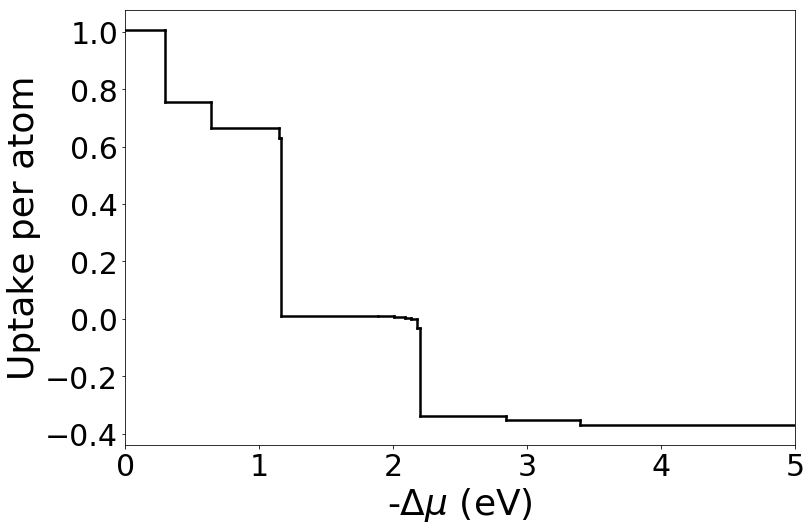

In [8]:
%matplotlib inline
from pymatgen.analysis.phase_diagram import PDPlotter
plotter = PDPlotter(pd)
plt = plotter.plot_element_profile("Na", entry.composition)